# Selección de atributos evolutiva multi-objetivo para regresión (pymoo)

### Descripción

<font size="4"> Selección de atributos para regresión utilizando un algoritmo evolutivo multi-objetivo (minimización) con la plataforma pymoo.

### Componentes

- <font size="3"> Método wrapper con Random Forest y métrica MSE
    
- <font size="3"> Datos:
    
    - <font size="3"> Regresión

    - <font size="3"> Entradas numéricas y categóricas 
    
- <font size="3"> Algoritmo evolutivo:
    
    - <font size="3"> Representación binaria

    - <font size="3"> Algoritmo evolutivo multi-objetivo NSGA-II

    - <font size="3"> Cruce two point

    - <font size="3"> Mutación bit flip

### Comentarios
    
- <font size="3"> Se leen los datos en formato arff.
    
- <font size="3"> Se imputan los missing values con la media (atributos numéricos) o la moda (atributos categóricos).
    
- <font size="3">  Para la evaluación de los modelos, los atributos de entrada categóricos se transforman a atributos binarios con one hot encoding.
        
---


### Requerimientos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,RepeatedKFold
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.util.plotting import plot
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.indicators.gd import GD
from pymoo.indicators.gd_plus import GDPlus
from pymoo.indicators.igd import IGD
from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.hv import HV
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair

### Lectura de los datos
#### Input:
  - $file\_path$: Nombre completo con path de la base de datos .arff a cargar
  
#### Output:
  - $X$: Atributos de entrada numéricos y categóricos
  - $y$: Salida numérica

In [2]:
def LoadData(file_path):

    data, meta = arff.loadarff(file_path)

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Separar atributos numéricos y categóricos
    numeric_attributes = df.iloc[:, :-1] .select_dtypes(include=['int', 'float']).columns
    categorical_attributes =  df.iloc[:, :-1].select_dtypes(include=['object']).columns

    # Imputación para atributos numéricos
    if numeric_attributes.size>0:
        df[numeric_attributes] = SimpleImputer(strategy='mean').fit_transform(df[numeric_attributes])
        
    # Imputación para atributos categóricos
    if categorical_attributes.size>0:
        df[categorical_attributes] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_attributes])

    # Separar en entradas (X) y salida (y)    
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]                      # Salidas: y (la última columna)
    
    return X,y

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $p\_c$: Probabilidad de cruce
- $p\_m$: Probabilidad de mutación
- $random\_state$: Semilla para reproducibilidad
- $X,y$: Datos
- $Phi$: Algoritmo de aprendizaje
- $cv$: Cross Validation Folds

In [3]:
G = 100
N = 10
p_c = 0.7
p_m = 0.1
random_state=1

file_path = "../DATASETS/ICU_train.arff"

X,y = LoadData(file_path)

Phi =  RandomForestRegressor(n_estimators=10, random_state=1)

k = 5
cv = KFold(n_splits=k)
#cv = RepeatedKFold(n_splits=k, n_repeats=1, random_state=1)

### Definición del problema de optimización multi-objetivo

$\textit{Minimizar} \ f_1(\textbf{x})=\displaystyle\sum_{l=1}^n x_l$

$\textit{Minimizar} \ f_2(\textbf{x}) = MSE(D_\textbf{x},\Phi,k)$
- $\textbf{x}=\{x_1,\ldots,x_n\}, x_l\in \{0,1\}, \ l=1,\ldots,n$ donde cada componente $x_l$ representa que el atributo $l$ ha sido seleccionado (si $x_l=1$) o no seleccionado (si $x_l=0$)
- $D_\textbf{x} = (X_\textbf{x},y)$: Dataset con los atributos seleccionados en $\textbf{x}$
- $\Phi$: Algoritmo de aprendizaje
- $k$: Número de folds para cross-validation (típicamente $k=5$)

In [4]:
class OneAttributeAtLeast(Repair):
    def _do(self, problem, Z, **kwargs):
        # repair each indvidiual x
        for x in Z:
            if sum(x) == 0:
                x[np.random.randint(len(x))] = 1 
        return Z

class MultiObjectiveFeatureSelection(ElementwiseProblem):

    def __init__(self,X,y,Phi,cv):
        super().__init__(n_var=len(X.T),n_obj=2,xl=0,xu=1)
        self.X = X
        self.y = y
        self.Phi = Phi
        self.cv = cv

    def _evaluate(self, x, out, *args, **kwargs):
        
        f1 = sum(x)
        
        # Seleccionar atributos del dataset
        X_selected = X.iloc[:, np.where(x == 1)[0]]

        # Identificar los atributos categóricos
        X_selected_categorical = X_selected.select_dtypes(include=['object']).columns

        # Aplicar hot encoding
        X_selected_encoded = pd.get_dummies(data=X_selected, columns=X_selected_categorical)    

        # Se evalúa el modelo en k-fold cross-validation
        scores = cross_val_score(estimator=self.Phi, X=X_selected_encoded, y=self.y, scoring='neg_mean_squared_error', cv=self.cv, n_jobs=-1)

        f2 = -np.mean(scores)
        
        out["F"] = [f1, f2]
        
    def _calc_pareto_front(self):
        n_pareto_points = len(self.X.T)+1
        pf = np.zeros((n_pareto_points,2))
        for i in range(n_pareto_points):
            pf[i][0] = i
        pf[0][1] = 1.0
        return pf

### Construcción del problema

In [5]:
problem = MultiObjectiveFeatureSelection(X=X,y=y,Phi=Phi,cv=cv)

### Visualización de puntos

In [6]:
def VisualizacionPuntos(title,values):
    scatter = Scatter(angle=(45, 45), title=title)
    scatter.add(values)
    scatter.show()
    plt.title(title)
    plt.show()

### Frente de Pareto (población ideal) para el cálculo de los indicadores de rendimiento
- $n\_points$: Número de puntos de la población ideal. El frente de Pareto real es desconocido en este problema, se usa por tanto una población ideal.

Número de puntos de la población ideal  ../DATASETS/ICU_train.arff  : 20


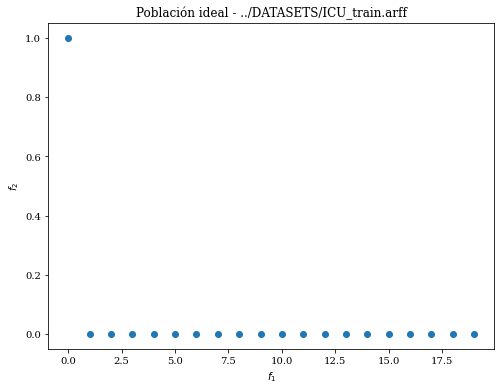

In [7]:
pf = problem.pareto_front()
print("Número de puntos de la población ideal ",file_path," :",len(pf))    

title = "Población ideal - "+file_path
VisualizacionPuntos(title,pf)

### Construcción de las instancias del algoritmo

In [8]:
sampling=BinaryRandomSampling()
crossover=TwoPointCrossover(prob=p_c)
mutation=BitflipMutation(prob=p_m)
algorithm = NSGA2(
        pop_size=N,
        sampling=sampling,
        crossover=crossover,
        mutation=mutation,
        repair=OneAttributeAtLeast())

### Ejecución del algoritmo

In [9]:
termination = get_termination("n_gen", G)
print("Problema: ",file_path)
print("Algoritmo: NSGA2")
res = minimize(problem=problem,
               algorithm=algorithm,
               termination=termination,
               seed=random_state,
               save_history=True,
               eliminate_duplicates=True,
               verbose=True)

Problema:  ../DATASETS/ICU_train.arff
Algoritmo: NSGA2
n_gen  |  n_eval  | n_nds  |      igd      |       gd      |       hv     
     1 |       10 |      1 |  0.3571242466 |  0.1487626488 |  0.5376235903
     2 |       20 |      2 |  0.3469605255 |  0.1510763573 |  0.5821820078
     3 |       30 |      2 |  0.3469605255 |  0.1510763573 |  0.5821820078
     4 |       40 |      3 |  0.3422191449 |  0.1626851641 |  0.6250292301
     5 |       50 |      4 |  0.3145406925 |  0.1529658368 |  0.6269345130
     6 |       60 |      4 |  0.3137197596 |  0.1523260546 |  0.6284161138
     7 |       70 |      2 |  0.3070050764 |  0.1454294545 |  0.6747900858
     8 |       80 |      2 |  0.3561767192 |  0.1434976761 |  0.6775073601
     9 |       90 |      3 |  0.3270758659 |  0.1415649410 |  0.6798475124
    10 |      100 |      3 |  0.3227912438 |  0.1397369936 |  0.7253837090
    11 |      110 |      4 |  0.3223268456 |  0.1393999337 |  0.7256423413
    12 |      120 |      4 |  0.3781638890 | 

### Valores de la solución y fitness

In [10]:
print("Base de datos: ",file_path)
print("Algoritmo: NSGA2")
print("Solución: \nX = %s\nF = %s" % (res.X, res.F))

Base de datos:  ../DATASETS/ICU_train.arff
Algoritmo: NSGA2
Solución: 
X = [[ True False False False False False False False  True False False  True
  False False False False  True  True False]
 [ True False False False False False False False  True False False  True
  False False False False False False  True]
 [ True False False False False False False False False False False False
  False False False False False False False]
 [ True False False False False False False False  True False False False
  False False False False False False False]
 [ True False  True False False False False False  True False False False
  False False False False False False False]]
F = [[5.         0.13629036]
 [4.         0.13808702]
 [1.         0.18169367]
 [2.         0.14817258]
 [3.         0.14235519]]


### Visualización de las soluciones

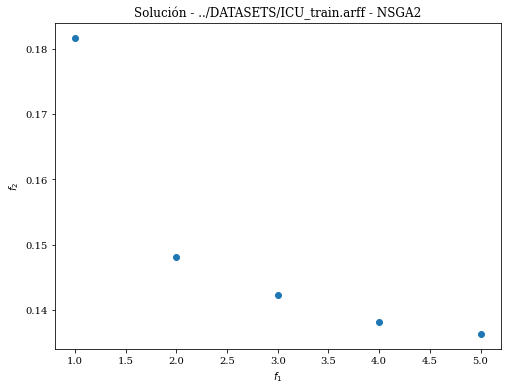

In [11]:
title = "Solución - "+file_path+" - NSGA2"
VisualizacionPuntos(title,res.F)

### Indicadores de rendimiento

In [12]:
print("Base de datos:",file_path)    
nadir = [len(X.T),1.0]
maxArea = len(X.T)
indicator = [
        GD(pf),
        GDPlus(pf),
        IGD(pf),
        IGDPlus(pf),
        HV(nadir)
]
cadena = " \t \t "
print("NSGA2 \t \t \t ")
for iIndicator in range(len(indicator)):
    cadena = indicator[iIndicator].__class__.__name__+" \t "
    if (len(cadena)<10):
        cadena += " \t "
        cadena += str(indicator[iIndicator](res.F))+" \t "
    print(cadena)
cadena = "HV normalized \t "
cadena += str(indicator[len(indicator)-1](res.F)/maxArea)+" \t "
print(cadena)

Base de datos: ../DATASETS/ICU_train.arff
NSGA2 	 	 	 
GD 	  	 0.149319763152247 	 
GDPlus 	  	 0.149319763152247 	 
IGD 	  	 5.35344431332193 	 
IGDPlus 	 
HV 	  	 15.48162655808673 	 
HV normalized 	 0.8148224504256173 	 


### Visualización de la evolución del algoritmo

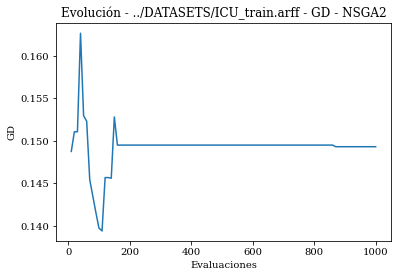

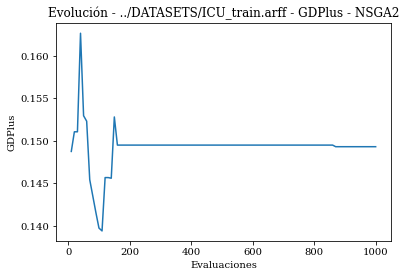

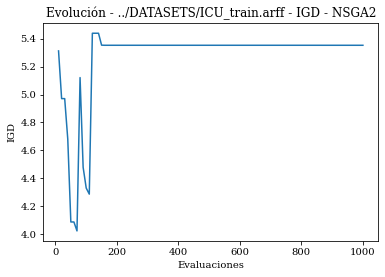

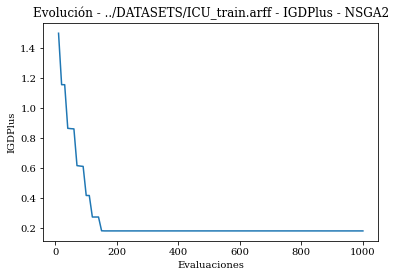

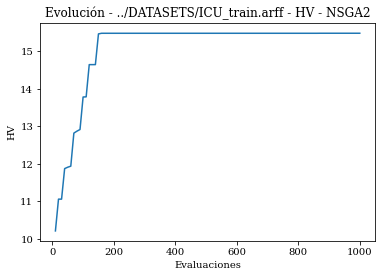

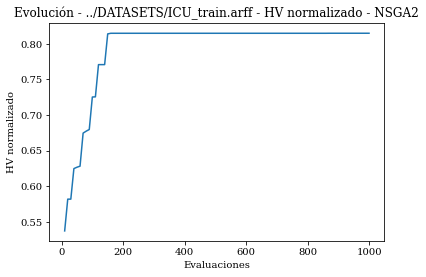

In [13]:
def VisualizacionEvolucion(title,n_evals,values,yTitle):    
    fig, ax = plt.subplots()
    ax.set_title(title)
    plt.plot(n_evals, values)
    plt.xlabel("Evaluaciones")
    plt.ylabel(yTitle)
    plt.show() 

n_evals = np.array([e.evaluator.n_eval for e in res.history]) # array con los números de evaluaciones
for iIndicator in range(len(indicator)):
    title = "Evolución - "+file_path+" - "+indicator[iIndicator].__class__.__name__+" - NSGA2"
    values = np.array([indicator[iIndicator](e.opt.get("F")) for e in res.history])
    yTitle = indicator[iIndicator].__class__.__name__
    VisualizacionEvolucion(title,n_evals,values,yTitle)
values = np.array([indicator[len(indicator)-1](e.opt.get("F")) for e in res.history])/maxArea
title = "Evolución - "+file_path+" - HV normalizado - NSGA2"
VisualizacionEvolucion(title,n_evals,values,"HV normalizado")

### Solución con todos los atributos

In [14]:
n = len(X.T)
X_selected_categorical = X.select_dtypes(include=['object']).columns
X_selected_encoded = pd.get_dummies(data=X, columns=X_selected_categorical)    
scores = cross_val_score(estimator=Phi, X=X_selected_encoded, y=y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
rmse = np.sqrt(-np.mean(scores))
print("Número total de atributos:",n)
print("rmse con todos los atributos: ",rmse)

Número total de atributos: 19
rmse con todos los atributos:  0.44902672526253934
